In [94]:
from spectralradex import radex
import numpy as np
from astropy import units as u 
from astropy import constants as c
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from multiprocessing import Pool
import seaborn as sns
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')
plt.style.use('paper')

In [14]:
params = radex.get_example_grid_parameters()

params['tkin'] = np.arange(30, 150, 5)
params['h2'] = 10**np.arange(1, 8, 0.05)
params['linewidth'] = [1, 5, 10, 20]

N_h2 = 8.5e22 
X_hnco = 10**np.arange(-10, -5, 0.05)
params['cdmol'] = X_hnco * N_h2

params['molfile'] = 'hnco.dat'
params['fmin'] = 87.925
params['fmax'] = 87.926

renrun = False
if renrun:
    pool=Pool(14)
    grid_df = radex.run_grid(params, target_value="T_R (K)", pool=pool)
    grid_df.to_csv('./../data/radex/grid_df.csv')
else: 
    print('[INFO] No rerun')


[INFO] No rerun


In [111]:
grid = Table.read('./../data/radex/grid_df.csv')

grid['col0'].name = 'id'
grid['h2'].name = 'n_h2'
grid['cdmol'].name = 'N_hnco'
grid['(4_0_4)-(3_0_3)[87.92523962 GHz]'].name = 'I_hnco'

# Some the values did not converge are are missing, which makes assigning an Xhnco a little difficult
X_hnco_column = []
for id in tqdm(range(len(grid))):
    where = np.float32(grid['N_hnco'][id]) == np.float32(np.round(N_hnco))
    X_hnco_column += [np.round(X_hnco[np.where(where)[0][0]], 15)]
grid.add_column(X_hnco_column, name='X_hnco')

mask = (grid['I_hnco']>1)&(grid['I_hnco']<5)
grid.add_column(mask*1, name='mask')

  0%|          | 0/432000 [00:00<?, ?it/s]

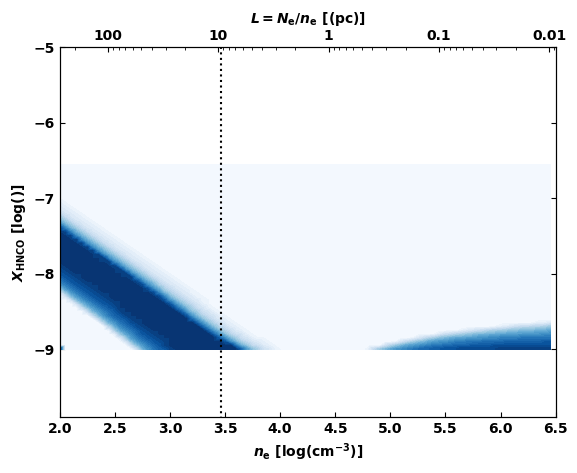

In [221]:
for linewidth in [params['linewidth'][0]]:

    grid_masked = grid[grid['linewidth'] == linewidth]

    for tkin in params['tkin']:

        grid_masked_tkin = grid_masked[grid_masked['tkin'] == tkin].copy()

        if tkin == params['tkin'][0]:
            z = grid_masked_tkin['mask']
        else: 
            z+=grid_masked_tkin['mask']

    z[0] = z.max()+1

    x = np.log10(grid_masked_tkin['n_h2'])
    y = np.log10(grid_masked_tkin['X_hnco'])

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()

    ax1.tricontourf(x, y, z, levels=np.arange(0,z.max()+1,1), cmap='Blues')

    ax1.set_xlabel("$n_\mathrm{e}$ [log(cm$^{-3})]$")
    ax1.set_ylabel("$X_\mathrm{HNCO}$ [log()]")

    ax1.set_xlim([2,6.5])
    ax1.set_ylim([-9.9,-5])

    def tick_function(n, N):
        L = (N/(u.cm*u.cm))/(n/(u.cm*u.cm*u.cm))
        L = L.to('pc').value
        return L

    ax2.set_xlabel("$L = N_\mathrm{e}/n_\mathrm{e}$ [(pc)]")
    new_xlim = tick_function(10**np.array(ax1.get_xlim()), N_h2)
    ax2.set_xlim(new_xlim)
    ax2.set_xscale('log')
    ax2.set_xticks([1e2, 1e1, 1, 1e-1, 1e-2])
    ax2.set_xticklabels([100, 10, 1, 0.1, 0.01])
    ax2.plot([9.4,9.4],[-11,0],'k:')

    fig.savefig('./../figures/radex_grid_linewidth_%ikms.png' %linewidth, bbox_inches='tight', transparent=False)

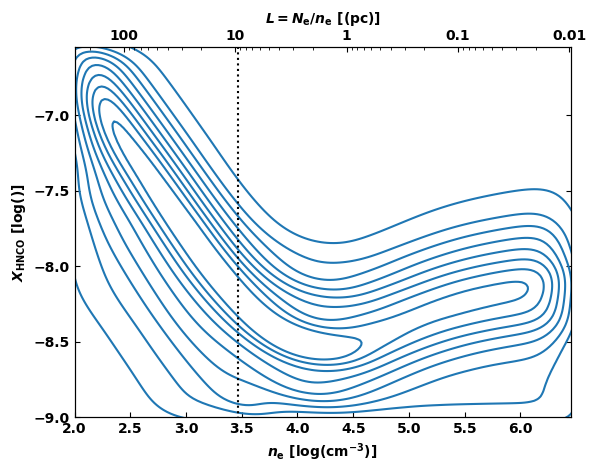

In [225]:
grid_masked = grid[mask]
# grid_masked = grid_masked[grid_masked['linewidth'] == 20]

grid_masked['n_h2'] = np.log10(grid_masked['n_h2'])
grid_masked['X_hnco'] = np.log10(grid_masked['X_hnco'])

grid_masked.write('./../data/radex/grid_masked.csv', overwrite=True)
grid_df_masked = pd.read_csv("./../data/radex/grid_masked.csv")

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

# sns.kdeplot(ax=ax1, data=grid_df_masked, x="nh2", y="X_hnco", fill=True, cmap='Blues')
sns.kdeplot(ax=ax1, data=grid_df_masked, x="n_h2", y="X_hnco", color='C0')

ax1.set_xlabel("$n_\mathrm{e}$ [log(cm$^{-3})]$")
ax1.set_ylabel("$X_\mathrm{HNCO}$ [log()]")
ax2.set_xlabel("$L = N_\mathrm{e}/n_\mathrm{e}$ [(pc)]")

def tick_function(n, N):
    L = (N/(u.cm*u.cm))/(n/(u.cm*u.cm*u.cm))
    L = L.to('pc').value
    return ["%.2f" % z for z in L]

ax1.set_xlim([grid_masked['n_h2'].min(), grid_masked['n_h2'].max()])
ax1.set_ylim([grid_masked['X_hnco'].min(), grid_masked['X_hnco'].max()])

def tick_function(n, N):
    L = (N/(u.cm*u.cm))/(n/(u.cm*u.cm*u.cm))
    L = L.to('pc').value
    return L

# ax2.plot(range(100), np.ones(100)) # Create a dummy plot
ax2.set_xlabel("$L = N_\mathrm{e}/n_\mathrm{e}$ [(pc)]")
new_xlim = tick_function(10**np.array(ax1.get_xlim()), N_h2)
ax2.set_xlim(new_xlim)
ax2.set_xscale('log')
ax2.set_xticks([1e2, 1e1, 1, 1e-1, 1e-2])
ax2.set_xticklabels([100, 10, 1, 0.1, 0.01])

ax2.plot([9.4,9.4],[-11,0],'k:')